# <center> Random Forest Regressor
**Summary of Actions**
* Custom RMSE evaluation metric on logged values
* A simlpe rangom forest regressor model
 

### Import Preliminaries

In [1]:
%matplotlib inline

# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

# Import data
train_df = pd.DataFrame(pd.read_csv(
    'https://www.dropbox.com/s/8ftdd4tejbmesy4/featured_train_df.csv?dl=1', index_col='Id'))
test_df = pd.DataFrame(pd.read_csv(
    'https://www.dropbox.com/s/h672z8790ehkxuj/featured_test_df.csv?dl=1', index_col='Id'))

# Set pandas options
pd.set_option('precision', 1)
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)
pd.set_option('precision', 3)

# List of dataframe
dfs = [train_df, test_df]

### DataFrame to Values

In [2]:
# Convert training and test data to values
X = train_df.loc[:, train_df.columns != 'SalePrice'].copy().values
y = train_df.SalePrice.values
X_test = test_df.values

### Fitting the Model 

In [3]:
# Creating and fitting the model
model = RandomForestRegressor()
model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Model Predictions

In [4]:
# create predictions dataframe
predictions = pd.DataFrame(test_df.index)
saleprice = pd.DataFrame(model.predict(X_test),
                          columns=['SalePrice'])
predictions = pd.concat([predictions, saleprice],axis=1)

# View test predictions

In [5]:
# View training predictions
train_df_prediction = pd.DataFrame(model.predict(X), columns=['Pred SalePrice'])
train_df_prediction = train_df_prediction.set_index(train_df.index)
train_df_prediction = pd.concat([train_df['SalePrice'], train_df_prediction], axis=1)
train_df_prediction.sample(3)

,SalePrice,Pred SalePrice
Id,,
1168,173000.0,176740.0
393,106500.0,107800.0
232,403000.0,385821.3


### Residual Plot

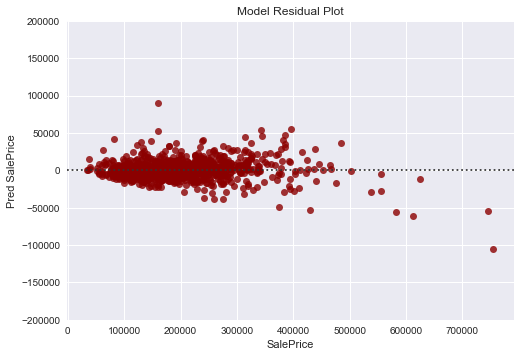

In [6]:
# Plotting training data residuals
residplot = sns.residplot(
    train_df.SalePrice, train_df_prediction['Pred SalePrice'], color='darkred')
plt.title('Model Residual Plot')
residplot.set(ylim=(-200000, 200000))
residplot

### Model Crossvalidation

In [7]:
# Creating list to store KFold scores
scores = list()

# Retrieve KFold scorse on test data, 10 folds
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)

    y_pred = pd.Series(model.predict(X_test))
    y_test = pd.Series(y_test)

    rmse = sqrt(mean_squared_error(np.log(y_test), np.log(np.abs(y_pred))))

    scores.append(rmse)

# Mean Logged RMSE Evaulation metric for our model
scores = pd.Series(scores, name='Scores')
print('Logged RMSE:', round(scores.mean(),4))

Logged RMSE: 0.1508


### Recursive Feature Elimination

In [8]:
selector = RFECV(estimator=model, cv=10,
                scoring='neg_mean_squared_error')
selector.fit(X,y)
print('Optimal Number of Features %d' %selector.n_features_)

Optimal Number of Features 242


In [9]:
# Print the Optimal Features
rfeatures = train_df.drop(['SalePrice'], axis=1).columns[selector.support_]
pd.Series(rfeatures).sample(10)

235     SaleType_medium
105    Exterior2nd_good
56      BsmtFinType1_gm
61      BsmtFinType2_gm
97     ExterQual_medium
99        ExterQual_bad
83        Condition2_mb
80      Condition2_good
112        Fence_medium
131       GarageCond_mb
dtype: object

In [10]:
# Reduced Datafarme to Values
X = train_df[list(rfeatures)].values
y = train_df.SalePrice.values
X_test = test_df[list(rfeatures)].values

# Fit the Model
model = RandomForestRegressor()
model.fit(X,y)

# create predictions dataframe
predictions = pd.DataFrame(test_df.index)
saleprice = pd.DataFrame(model.predict(X_test),
                          columns=['SalePrice'])
predictions = pd.concat([predictions, saleprice],axis=1)

### Export Results

In [11]:
# Exporting data without index
predictions.to_csv('Submissions/rfg_recursive_predicition.csv', index=False)

### Accuracy Scores

<br>Feature Enginnering 4 - RMSE: 0.1529

### Kaggle Scores

<br>Feature Engineering 4 - RMSE: 0.15486